In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

from tqdm import trange
import random


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [3]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [5]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [6]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


# 데이터셋

In [7]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp["Patv"]
            #train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y



In [8]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:16<00:00,  8.33it/s]


In [9]:
len(X_data)

25996

In [10]:
X_data[0].shape

(720,)

In [11]:
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], 1)
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

In [12]:
X_data.shape

(25996, 720, 1)

In [13]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

In [14]:
train_x, valid_x, train_y, valid_y = train_test_split(X_data,Y_data, test_size=0.1, shuffle=False,random_state=42)

In [15]:
np.array(train_y).shape

(23396, 288)

In [16]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)
print(train_x.shape, train_y.shape)

(23396, 720, 1) (23396, 288)


In [17]:
valid_x  = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)
print(valid_x.shape, valid_y.shape)

(2600, 720, 1) (2600, 288)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

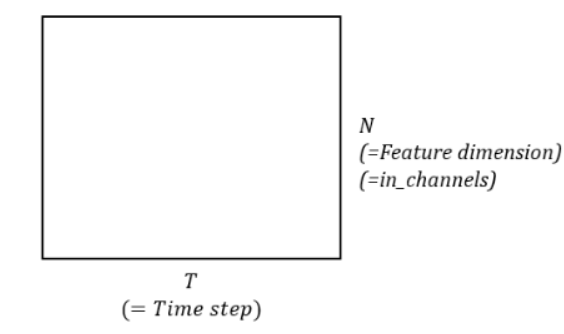

# 정규화

std norm 을 이용하고, inference 후 , 다시 복구 시킨다

In [18]:
global_mean=train_x.mean()

In [19]:
global_std=train_x.std()

In [20]:
train_x=(train_x-global_mean)/(global_std)
train_y=(train_y-global_mean)/(global_std)

In [21]:
valid_x=(valid_x-global_mean)/(global_std)
valid_y=(valid_y-global_mean)/(global_std)

# 데이터 로더

In [22]:
EPOCHS = 15
BATCH_SIZE = 128
lr = 1e-3
lstm_hidden_layer=128

In [23]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [24]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [25]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 720, 1]) type: torch.FloatTensor
Y_train :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


In [26]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([128, 720, 1]) type: torch.FloatTensor
Y_valid :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [27]:
lstm = nn.LSTM(input_size=1, hidden_size=256, batch_first=True, bidirectional=True)

lstm(X_valid)[0].size()

torch.Size([128, 720, 512])

In [28]:
lstm(X_valid)[0][-1].size()

torch.Size([720, 512])

In [29]:
lstm(X_valid)[1][0]

tensor([[[-0.0244,  0.0471,  0.0487,  ..., -0.0059,  0.0228,  0.0513],
         [ 0.0094,  0.0762,  0.0056,  ...,  0.0250,  0.0110,  0.0266],
         [-0.0244,  0.0467,  0.0493,  ..., -0.0062,  0.0225,  0.0514],
         ...,
         [-0.0299,  0.0401,  0.0593,  ..., -0.0121,  0.0240,  0.0557],
         [-0.0301,  0.0438,  0.0535,  ..., -0.0095,  0.0263,  0.0547],
         [-0.0299,  0.0401,  0.0593,  ..., -0.0121,  0.0240,  0.0557]],

        [[-0.0183, -0.0208,  0.0216,  ...,  0.0324, -0.0005, -0.0267],
         [ 0.0232, -0.0076,  0.0832,  ..., -0.0406, -0.0644, -0.0319],
         [-0.0222, -0.0206,  0.0211,  ...,  0.0253, -0.0009, -0.0282],
         ...,
         [ 0.0008, -0.0161,  0.0485,  ...,  0.0043, -0.0267, -0.0293],
         [-0.0285, -0.0244,  0.0065,  ...,  0.0472,  0.0144, -0.0259],
         [ 0.0030, -0.0146,  0.0519,  ...,  0.0009, -0.0306, -0.0290]]],
       grad_fn=<StackBackward0>)

In [30]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 512])

In [31]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [32]:
lsenc=lstm_encoder(input_size=1, hidden_size=256)

In [33]:
X_valid.unsqueeze(2).size()

torch.Size([128, 720, 1, 1])

In [34]:

hidden=lsenc(X_valid)[1]

In [35]:
hidden

(tensor([[[-0.0175, -0.0522, -0.0005,  ..., -0.0114,  0.0295,  0.0107],
          [-0.0384,  0.0076, -0.0213,  ..., -0.0080,  0.0073, -0.0033],
          [-0.0174, -0.0527, -0.0002,  ..., -0.0114,  0.0298,  0.0111],
          ...,
          [-0.0131, -0.0664,  0.0048,  ..., -0.0129,  0.0343,  0.0132],
          [-0.0148, -0.0600,  0.0020,  ..., -0.0126,  0.0312,  0.0103],
          [-0.0131, -0.0664,  0.0048,  ..., -0.0129,  0.0343,  0.0132]]],
        grad_fn=<StackBackward0>),
 tensor([[[-0.0362, -0.1026, -0.0009,  ..., -0.0238,  0.0565,  0.0213],
          [-0.0793,  0.0150, -0.0414,  ..., -0.0168,  0.0138, -0.0067],
          [-0.0359, -0.1037, -0.0005,  ..., -0.0237,  0.0572,  0.0221],
          ...,
          [-0.0271, -0.1308,  0.0098,  ..., -0.0268,  0.0659,  0.0263],
          [-0.0306, -0.1180,  0.0039,  ..., -0.0262,  0.0599,  0.0204],
          [-0.0271, -0.1308,  0.0098,  ..., -0.0268,  0.0659,  0.0263]]],
        grad_fn=<StackBackward0>))

In [36]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [37]:
X_valid[:,-1,:].unsqueeze(1).shape

torch.Size([128, 1, 1])

In [38]:
hidden

(tensor([[[-0.0175, -0.0522, -0.0005,  ..., -0.0114,  0.0295,  0.0107],
          [-0.0384,  0.0076, -0.0213,  ..., -0.0080,  0.0073, -0.0033],
          [-0.0174, -0.0527, -0.0002,  ..., -0.0114,  0.0298,  0.0111],
          ...,
          [-0.0131, -0.0664,  0.0048,  ..., -0.0129,  0.0343,  0.0132],
          [-0.0148, -0.0600,  0.0020,  ..., -0.0126,  0.0312,  0.0103],
          [-0.0131, -0.0664,  0.0048,  ..., -0.0129,  0.0343,  0.0132]]],
        grad_fn=<StackBackward0>),
 tensor([[[-0.0362, -0.1026, -0.0009,  ..., -0.0238,  0.0565,  0.0213],
          [-0.0793,  0.0150, -0.0414,  ..., -0.0168,  0.0138, -0.0067],
          [-0.0359, -0.1037, -0.0005,  ..., -0.0237,  0.0572,  0.0221],
          ...,
          [-0.0271, -0.1308,  0.0098,  ..., -0.0268,  0.0659,  0.0263],
          [-0.0306, -0.1180,  0.0039,  ..., -0.0262,  0.0599,  0.0204],
          [-0.0271, -0.1308,  0.0098,  ..., -0.0268,  0.0659,  0.0263]]],
        grad_fn=<StackBackward0>))

In [39]:
X_valid[:,-1,:].shape

torch.Size([128, 1])

In [40]:
lsde = lstm_decoder(input_size=1, hidden_size=256)
lsde(X_valid[:,-1,:] , hidden)

(tensor([[[-0.0556]],
 
         [[-0.0641]],
 
         [[-0.0555]],
 
         [[-0.0597]],
 
         [[-0.0631]],
 
         [[-0.0536]],
 
         [[-0.0581]],
 
         [[-0.0564]],
 
         [[-0.0675]],
 
         [[-0.0668]],
 
         [[-0.0538]],
 
         [[-0.0557]],
 
         [[-0.0568]],
 
         [[-0.0569]],
 
         [[-0.0566]],
 
         [[-0.0536]],
 
         [[-0.0620]],
 
         [[-0.0564]],
 
         [[-0.0564]],
 
         [[-0.0536]],
 
         [[-0.0591]],
 
         [[-0.0536]],
 
         [[-0.0556]],
 
         [[-0.0560]],
 
         [[-0.0536]],
 
         [[-0.0596]],
 
         [[-0.0582]],
 
         [[-0.0569]],
 
         [[-0.0568]],
 
         [[-0.0596]],
 
         [[-0.0629]],
 
         [[-0.0536]],
 
         [[-0.0536]],
 
         [[-0.0536]],
 
         [[-0.0594]],
 
         [[-0.0669]],
 
         [[-0.0569]],
 
         [[-0.0541]],
 
         [[-0.0560]],
 
         [[-0.0541]],
 
         [[-0.0536]],
 
         [[-0.05

In [41]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size).to(DEVICE)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out
        
        return outputs.squeeze()

    def predict(self, inputs, target_len):
        inputs = inputs
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size).to(DEVICE)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs[:,:,0]

In [42]:
X_valid.size()

torch.Size([128, 720, 1])

In [43]:
Y_valid.unsqueeze(-1).size()

torch.Size([128, 288, 1])

In [44]:
lsed=lstm_encoder_decoder(1,256)
lsed(inputs=X_valid,targets=Y_valid.unsqueeze(-1), target_len=288, teacher_forcing_ratio=0.6).size()

## 11 ->1 이 되도록 수정이 필요하다.

torch.Size([128, 288])

In [45]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=11, hidden_size=256, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [46]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(inputs=X, targets=Y.unsqueeze(-1),target_len=288, teacher_forcing_ratio=0.6) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [47]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(inputs=X,targets=Y.unsqueeze(-1),target_len=288, teacher_forcing_ratio=0.6) # model로 output을 계산
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [48]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_seq2seq_onecol.pt'
print(check_path)
model = lstm_encoder_decoder(1,lstm_hidden_layer).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_seq2seq_onecol.pt

[EPOCH:1]	 Train Loss:45.4339	 Train MAE:59.0877  | 	Valid Loss:2.7776 	Valid MAE: 4.4524

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 2.7776 


[EPOCH:2]	 Train Loss:23.5181	 Train MAE:39.1585  | 	Valid Loss:2.4778 	Valid MAE: 4.1747

-- SAVE Checkpoint --
Valid loss : 2.7776 -> 2.4778 


[EPOCH:3]	 Train Loss:22.2242	 Train MAE:37.1779  | 	Valid Loss:2.5350 	Valid MAE: 4.2931


[EPOCH:4]	 Train Loss:22.2474	 Train MAE:37.0498  | 	Valid Loss:2.4954 	Valid MAE: 4.2666


[EPOCH:5]	 Train Loss:22.0674	 Train MAE:36.9572  | 	Valid Loss:2.5114 	Valid MAE: 4.0109


[EPOCH:6]	 Train Loss:21.9815	 Train MAE:36.7540  | 	Valid Loss:2.5041 	Valid MAE: 4.3404


[EPOCH:7]	 Train Loss:21.9926	 Train MAE:36.7955  | 	Valid Loss:2.4773 	Valid MAE: 3.9528

-- SAVE Checkpoint --
Valid loss : 2.4778 -> 2.4773 


[EPOCH:8]	 Train Loss:21.9391	 Train MAE:36.7504  | 	Valid Loss:2.4482 	Valid MAE: 4.1364

-- SAVE Checkpoint --
Valid loss : 2.4773 -> 2.4482

# validation 확인

In [49]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 2.3896 / Valid MAE : 4.0459 



In [50]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 2.3896 / Valid MAE : 4.0459 



# TEST

In [56]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

#test_data = test_data.drop(["TurbID", "Day"], axis = 1)
test_data = test_data['Patv']

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0],1)
#train set 처럼 batch,720,11로 고치기


In [57]:
test_data.shape

(134, 720, 1)

In [58]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [59]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            #print(X.size())
            pred = model.predict(X, target_len=288)
            preds += pred.cpu().tolist()
    return np.array(preds)

In [61]:
model = lstm_encoder_decoder(1,lstm_hidden_layer).to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_seq2seq_onecol.pt')
model.load_state_dict(best_checkpoint)
model.eval()

lstm_encoder_decoder(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 128, batch_first=True)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 128, batch_first=True)
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [65]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)*global_std+global_mean

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.62it/s]


In [66]:
preds.shape

(38592,)

In [68]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)